# **Clusterização**

A clusterização se refere a uma técnica de aprendizado de máquina não supervisionado em que o modelo recebe entradas (features) e retorna grupos (clusters) de acordo com características semelhantes. O objetivo do modelo é enquadrar os dados em grupos, onde cada elemento do grupo tem aspectos parecidos e tem características diferentes de outros grupos. A clusterização é útil para identificação de padrões, segmentação de dados, detecção de anomalias (dados que fogem do padrão), entre outros propósitos.

A seguir, tem-se um caso de clusterização de clientes de uma empresa. O objetivo da análise é identificar clientes com características semelhantes no comportamento de compras e, a partir disso, a empresa pode personalizar ofertas de produtos e elaborar campanhas de marketing direcionadas a cada perfil de cliente, por exemplo.

## Importação dos Pacotes

In [ ]:
# !pip install -q threadpoolctl==3.1.0

In [46]:
# Bibliotecas
import threadpoolctl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Set seed
np.random.seed(42)

## Carregamento dos dados

In [48]:
# Carregando os dados
df = pd.read_csv(r"C:\Users\glauber.lima\Desktop\Glauber\7-FCD\dataset.csv")

In [49]:
# Informações do dataset
print("Shape dos dados\n")
print('Total de registros: ',df.shape[0],'\n')
print('Total de variáveis: ',df.shape[1])
print('-' * 50)
print('\nTipos de dados: \n')
print(df.dtypes)
print('-' * 50)
print('\nValores nulos: \n')
print(df.isnull().sum())
print('-' * 50)
print('\nTotal de valores duplicados: \n')
print(df.duplicated().sum())

Shape dos dados

Total de registros:  99 

Total de variáveis:  6
--------------------------------------------------

Tipos de dados: 

Idade                    int64
Gasto_Mensal           float64
Tempo_de_Assinatura      int64
Taxa_de_Uso            float64
Suporte_Tickets          int64
Cancelou                 int64
dtype: object
--------------------------------------------------

Valores nulos: 

Idade                  0
Gasto_Mensal           0
Tempo_de_Assinatura    0
Taxa_de_Uso            0
Suporte_Tickets        0
Cancelou               0
dtype: int64
--------------------------------------------------

Total de valores duplicados: 

0


In [50]:
# Visualizando uma amostra de 5 registros
df.sample(5)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
62,38,739.488554,15,0.547594,3,0
40,24,218.509402,1,0.422976,1,0
95,53,999.943535,23,0.865750,5,1
18,28,172.894435,3,0.110168,1,0
97,61,911.086341,22,0.848029,2,1


É importante destacar que a variável 'Cancelou' muito embora o python tenha identificado a variável como sendo numérica (dtype: int64), ela representa uma informação categórica, onde 0 representa que o cliente não cancelou a assinatura e 1 indica que o cliente cancelou a assinatura.

---

## Exploração dos dados

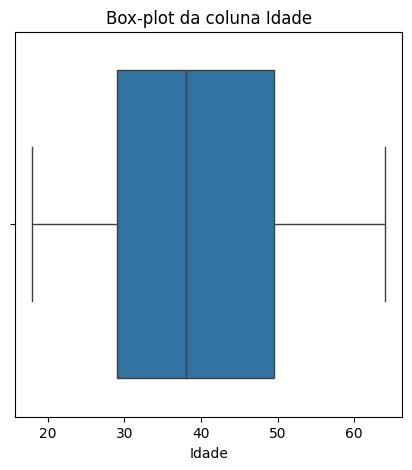

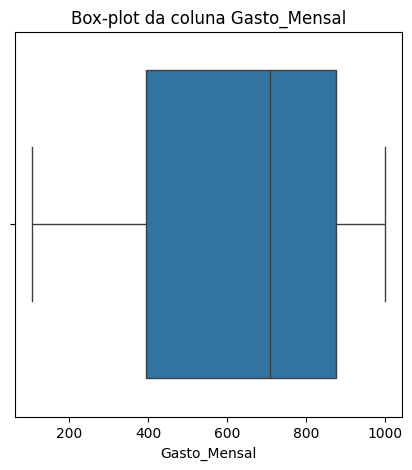

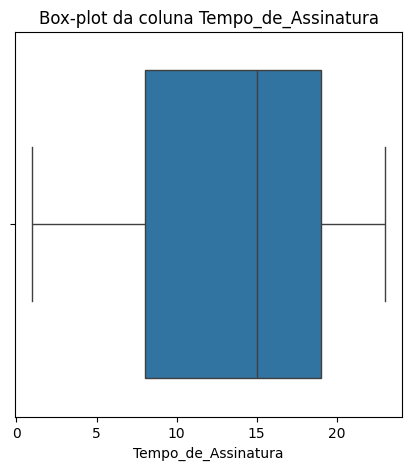

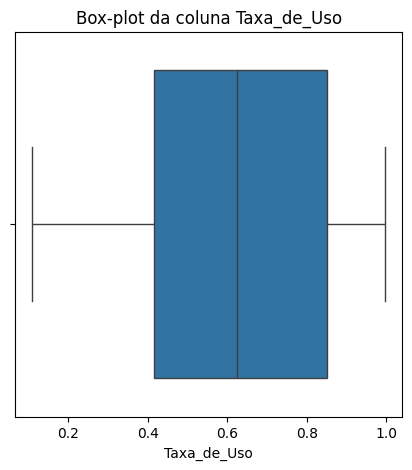

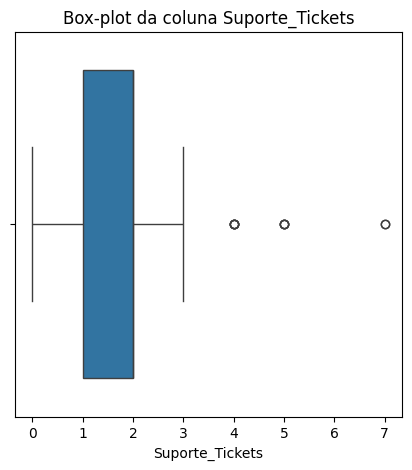

In [51]:
# Visualizando outliers para cada variável numérica
for col in df.columns:
  if (df[col].dtype in ['int64','float64']) and (col != 'Cancelou'):
    plt.figure(figsize = (5,5))
    sns.boxplot(x = df[col])
    plt.title(f"Box-plot da coluna {col}")
    plt.show()

É importante frisar pela análise de boxplot que as variáveis possuem distribuições sem a presença de outliers, com exceção para a variável 'Suporte_Tickets' que tem valores extremos que puxam a média para cima. Veremos isso na tabela de resumo estatístico.

In [52]:
# Contagem de registros da variável Cancelou
print('Contagem pela variável Cancelou\n',df['Cancelou'].value_counts())
print('\nPercentual da variável Cancelou\n',df['Cancelou'].value_counts(normalize=True).round(2))

Contagem pela variável Cancelou
 Cancelou
0    50
1    49
Name: count, dtype: int64

Percentual da variável Cancelou
 Cancelou
0    0.51
1    0.49
Name: proportion, dtype: float64


Nota-se que a variável Cancelou' possui uma proporção quase simétrica, ou seja, uma proporção de quase 50/50 entre clientes que cancelaram a assinatura e clientes que não cancelaram a assinatura.

In [53]:
# Resumo estatistico
df.describe()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,39.888889,639.071009,13.646465,0.604374,1.747475,0.494949
std,13.089869,270.618268,6.599804,0.263824,1.486974,0.502519
min,18.000000,106.254563,1.000000,0.110168,0.000000,0.000000
25%,29.000000,394.918421,8.000000,0.414928,1.000000,0.000000
50%,38.000000,709.104722,15.000000,0.623406,2.000000,0.000000
75%,49.500000,875.735422,19.000000,0.849839,2.000000,1.000000
max,64.000000,999.943535,23.000000,0.996007,7.000000,1.000000


---

## Pre-Processamento dos Dados

Na etapa de pré-processamento, o foco será remover os outliers. Para isso, usaremos a técnica do Intervalo Interquartil que pôde ser visto no boxplot das variáveis numéricas exibido anteriormente.
Desse modo, identificaremos os outliers da base de dados e então iremos filtrá-los. É importante destacar que usaremos o K-Means como algoritmo para agrupamento e, uma das características do K-Means é que ele trabalha com cálculos baseados em distância. Portanto, a presença de outliers e escala dos dados é algo que afeta o desempenho desse algoritmo. Desse modo, removeremos os outliers da base de análise. Posteriormente, trataremos a escala para garantir que isso não seja fator que atrapalhe o desempenho do K-Means.

### Tratamento de Outliers

In [54]:
# Intervalo inter-quartil
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [55]:
# Definindo os outliers
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis = 1)

In [56]:
# Visualizando os outliers
df[outliers]

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
12,46,743.034018,16,0.697133,5,0
52,41,595.076602,14,0.512320,4,1
53,48,550.847824,12,0.619646,7,1
54,43,667.040379,13,0.630056,5,0
63,34,694.989179,17,0.536049,7,1
79,59,805.273395,21,0.887495,4,1
80,45,875.292673,23,0.980832,4,1
87,52,968.423785,19,0.989904,4,1
89,56,893.738632,23,0.985318,4,1
95,53,999.943535,23,0.865750,5,1


In [ ]:
# Filtrando os outliers
df = df[~outliers]
print('Total de registros: ',df.shape[0])

Total de registros:  88


### Matriz de Correlação

A matriz de correlação é uma tabela que indica o grau de correlação que as variáveis numéricas têm umas com as outras. A correlação varia de -1 a 1, em que -1 é uma correlação negativa perfeita, 0 indica ausência de correlação e 1 é correlação positiva perfeita. Nesse contexto, a matriz de correlação é útil para identificar variáveis correlacionadas e fazer uma seleção das variáveis que irá para o modelo, uma vez que a multicolineraridade (variáveis que possuem alta correlação) é um problema para o K-Means por conta da redundãncia de informação.

In [60]:
# Matriz de correlação
mc = df.corr()

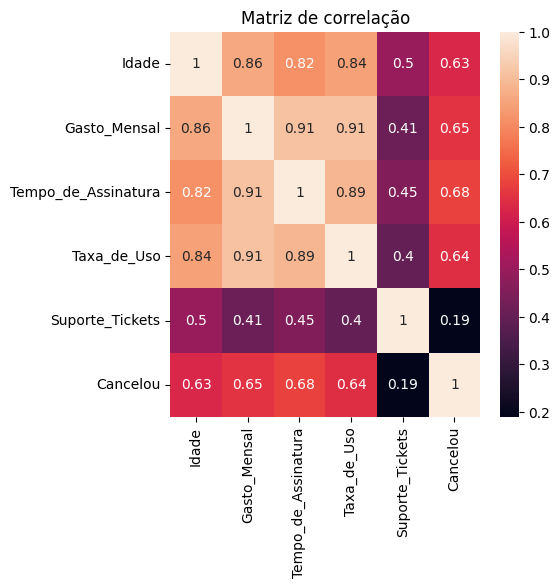

In [61]:
# Plot da matriz de correlaççao
plt.figure(figsize = (5,5))
sns.heatmap(mc, annot = True)
plt.title("Matriz de correlação")
plt.show()

A matriz de correlação indica que os pares de variáveis Idade-Gasto_Mensal, Idade-Tempo_Assinatura, Idade-Taxa_Uso, Gasto_Mensal-Tempo_Assinatura, Gasto_Mensal-Taxa_Uso, Tempo_Assinatura-Taxa_Uso possuem alta correlação (próximo a 1). Por hora, iremos manter essas variáveis no modelo e mensurar os resultados após treinar o modelo. Caso o K-Means não performe bem, uma das estratégias que pode ser adotada para otimizar o modelo é selecionar as variáveis com baixa correlação.

### Padronização dos dados

Iremos padronizar os dados utilizando o Stadard Scaler que consiste em "pegar" cada ponto de dado, subtrair da média da distribuição e dividir pelo desvio padrão da distribuição. O objetivo é deixar os dados na mesma escala.

In [62]:
# Scaler
sc = StandardScaler()

In [63]:
# Aplicação do Scaler
df_sc = pd.DataFrame(sc.fit_transform(df), columns = df.columns)

In [64]:
# Dados originais
df.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


In [65]:
# Dados padronizados
df_sc.head()

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou
0,0.684474,-0.328191,-0.008625,-0.219301,0.679005,1.095445
1,-0.143740,0.239046,-0.008625,0.177704,0.679005,-0.912871
2,-0.595492,0.649876,0.598590,0.475005,-0.369283,-0.912871
3,-0.670785,-0.281189,-0.160429,-0.245215,1.727292,-0.912871
4,0.383305,0.133145,0.294982,0.734060,1.727292,-0.912871


---

## Escolhendo o valor ótimo de clusters

Para saber o valor ótimo de clusters, não há um método definitivo que defina esse número. Entretanto, há métodos que podem ser usados para se ter uma noção do número de clusters ideal. Vale ressaltar que o ideal é fazer experimentação em relação à definição de clusters e essas técnicas servem com base para se chegar nesse número.
Iremos utilizar duas técnicas para isso: (1) Método de Elbow (ou Cotovelo) e (2) Método da Silhueta. Em ambos, utilizaremos uma análise gráfica a partir do SSE (Squared Sum Erros), Soma dos Erros Quadráticos que irá mensurar a variação total dentro de cada cluster.

In [66]:
# armazenar os SSE
sse = []

In [67]:
# Range de valores a serem testados
k_range = range(1,11)

In [68]:
# Testando os valores de k
for k in k_range:
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(df_sc)
  sse.append(kmeans.inertia_)

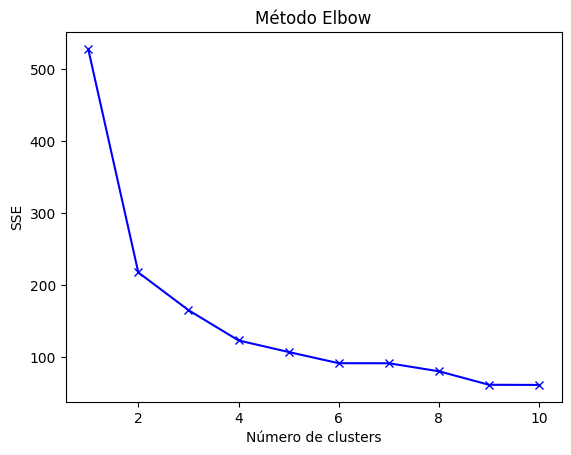

In [69]:
# Plot de Elbow
plt.plot(k_range, sse,'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método Elbow')
plt.show()

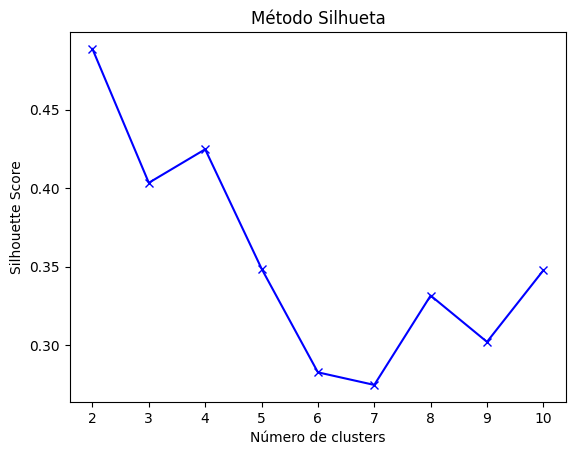

In [70]:
# Plot de Silhueta
sil = []
for k in k_range:
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(df_sc)
  if k != 1:
    sil.append(silhouette_score(df_sc, kmeans.labels_))

# Plot
plt.plot(k_range[1:], sil,'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Método Silhueta')
plt.show()

Agora iremos interpretar os gráficos e definir o número de clusters ideal a partir da interpretação.

**Método de Elbow**

O Método de Elbow possui esse nome, pois o gráfico se assemelha a um cotovelo. Observe no gráfico que, a medida que aumenta o número de clusters, reduz o valor do SSE. Todavia, a variação de redução do SSE de um número de cluster para outro é decrescente, isto é, com 1 cluster se tem um valor elevado de SSE; com 2 clusters, o SSE reduz consideravelmente, mas perceba que com 3 clusters esse valor reduz, mas não tanto quanto a primeira redução, portanto, essa redução acontece, mas a taxas decrescentes a medida que cresce o número de clusters. Desse modo, iremos escolher um número de cluster que a variação de um para outro não seja tão alta. Inicialmente, escolheremos o número ideal de 4 clusters.

**Método da Silhueta**

O Método de Silhueta é semelhante ao método de Elbow, entretanto utiliza o score de silhueta como métrica para definir o número ideal de clusters. Diferente do SSE, no score de silhueta, quanto maior o score melhor é o número ideal de clusters. Em razão disso, interpretanto o gráfico, manteremos a decisão de seguir com 4 clusters para análise incialmente.

## Construindo a primeira versão do modelo

In [71]:
# Modelo com 4 clusters
modelo = KMeans(n_clusters = 4, random_state = 42)

In [72]:
# Treina o modelo e salva o resultado na coluna Cluster
df['Cluster'] = modelo.fit_predict(df_sc)

In [73]:
# Amostra
df.sample(10)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,Cluster
15,28,433.277965,1,0.297518,0,0,3
88,50,967.665741,23,0.829415,3,1,1
94,49,962.580202,18,0.898524,2,1,1
36,20,334.700466,8,0.421469,0,0,3
48,32,755.902837,15,0.541506,0,1,2
68,55,936.946235,19,0.826803,2,1,1
70,48,982.185437,18,0.951027,1,1,1
10,32,588.077553,16,0.691481,0,1,2
45,32,217.395270,5,0.270843,2,0,3
72,63,989.959983,23,0.940816,1,0,1


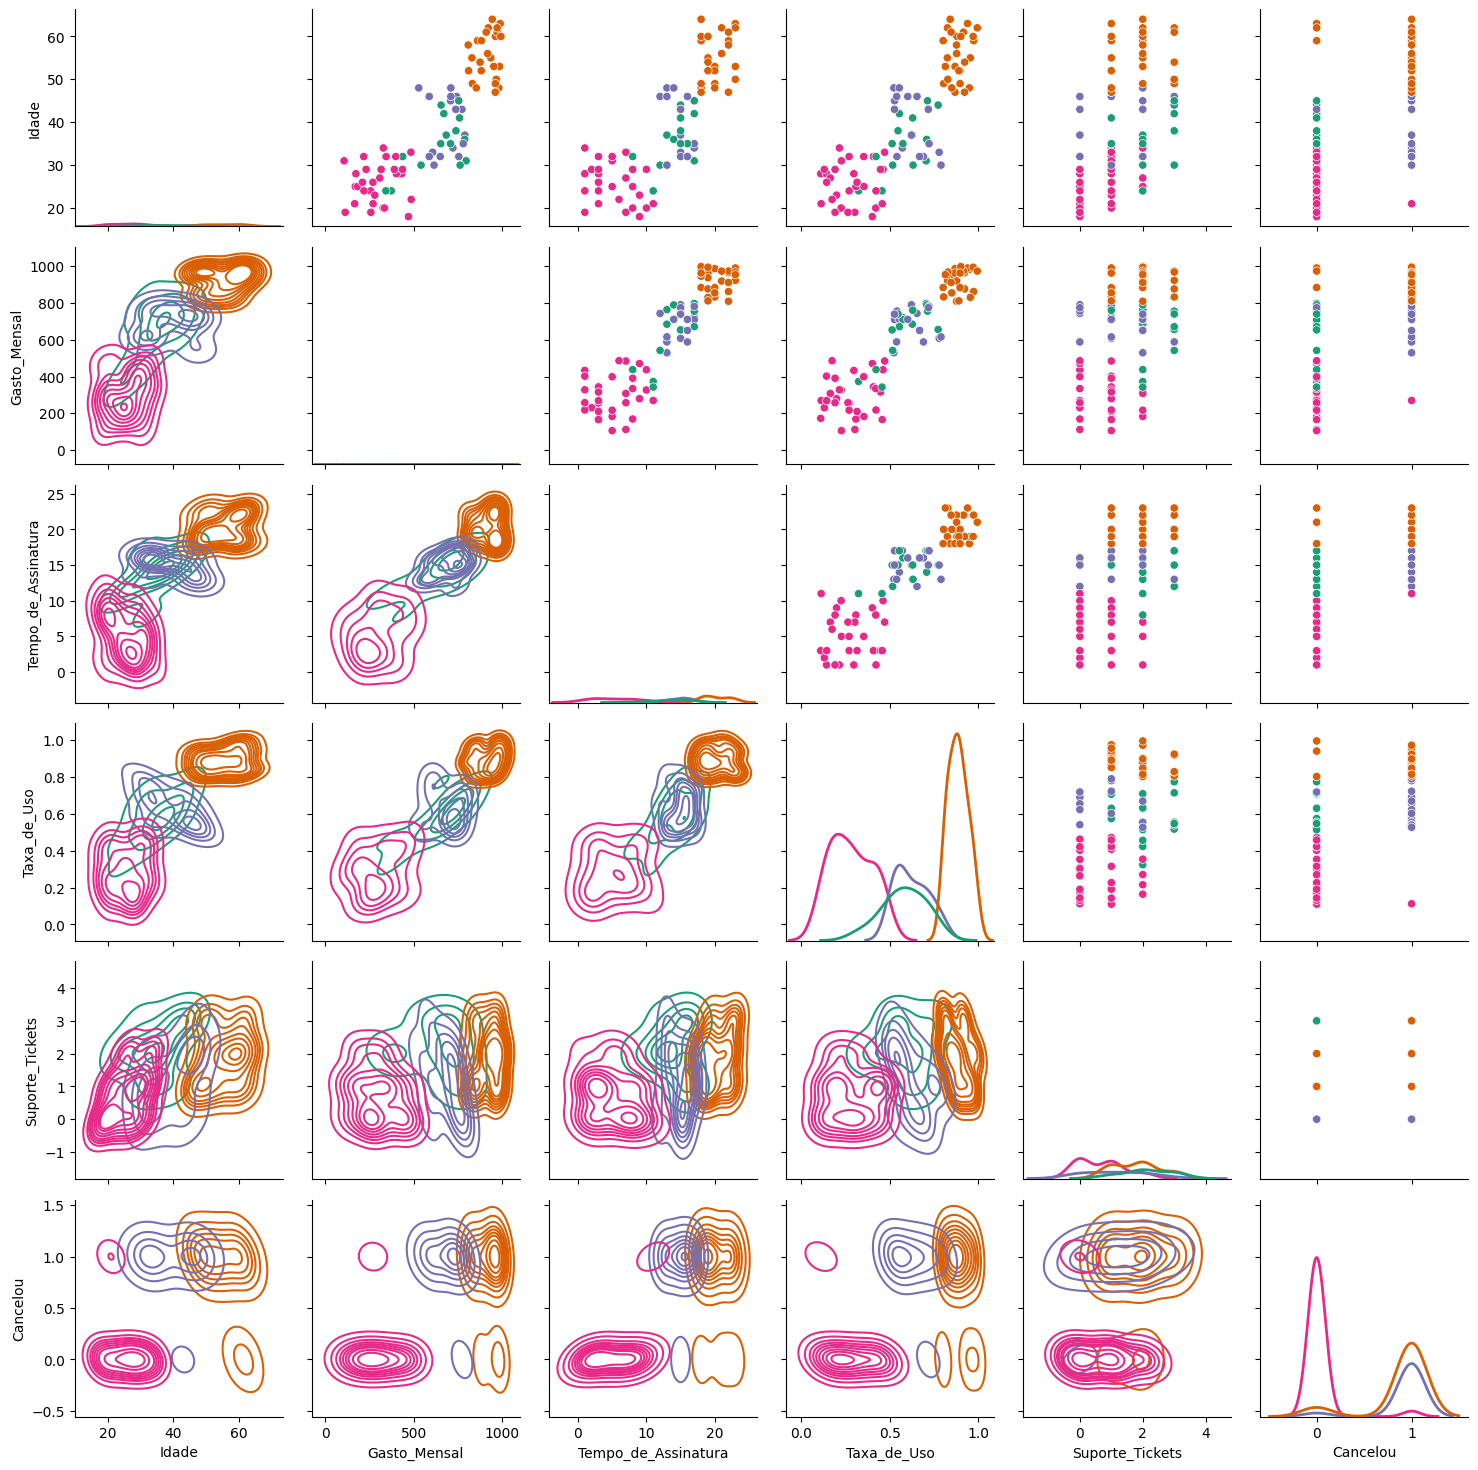

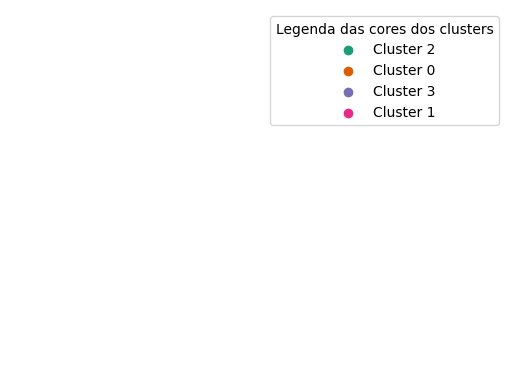

In [74]:
# Visualizar os clusters
# Pair Grid
palette = sns.color_palette('Dark2', n_colors = len(df['Cluster'].unique()))
color_map = dict(zip(df['Cluster'].unique(), palette))
# Criando o plot
g = sns.PairGrid(df, hue = 'Cluster', palette = palette)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()
# Mostrando o mapa de cores
for cluster, color in color_map.items():
  plt.scatter([],[],c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda das cores dos clusters')
plt.axis('off')
plt.show()

Perceba que com 4 clusters, a partir da análise gráfica, os clusters 0 e 1 ficaram sobrepostos, indicando que o K-Means não conseguiu distingui-los de forma eficiente, sinal que os dados são semelhantes e que faz sentido mudar de 4 para 3 o número de clusters. Faremos isso na próxima seção:

## Construindo a segunda versão do modelo

In [75]:
# Modelo com 3 clusters
modelo_v2 = KMeans(n_clusters = 3, random_state = 42)

In [76]:
# Copiando o dataframe df para um novo dataframe para comparar os clusters
df_v2 = df.copy()
df_v2.drop('Cluster', axis = 1, inplace = True)

In [77]:
# Treinar o modelo e salvar os resultados no dataframe
df_v2['Cluster'] = modelo_v2.fit_predict(df_sc)

In [78]:
# Amostra
df_v2.sample(10)

,Idade,Gasto_Mensal,Tempo_de_Assinatura,Taxa_de_Uso,Suporte_Tickets,Cancelou,Cluster
59,43,773.972166,15,0.719012,0,0,2
3,30,542.025205,12,0.517458,3,0,2
72,63,989.959983,23,0.940816,1,0,1
55,35,780.846432,17,0.723213,1,1,2
70,48,982.185437,18,0.951027,1,1,1
77,61,973.212778,22,0.917984,3,1,1
32,33,484.468810,7,0.471879,1,0,0
71,47,964.507449,22,0.924062,1,1,1
46,37,789.996446,15,0.623406,0,1,2
91,48,854.681414,20,0.851649,1,1,1


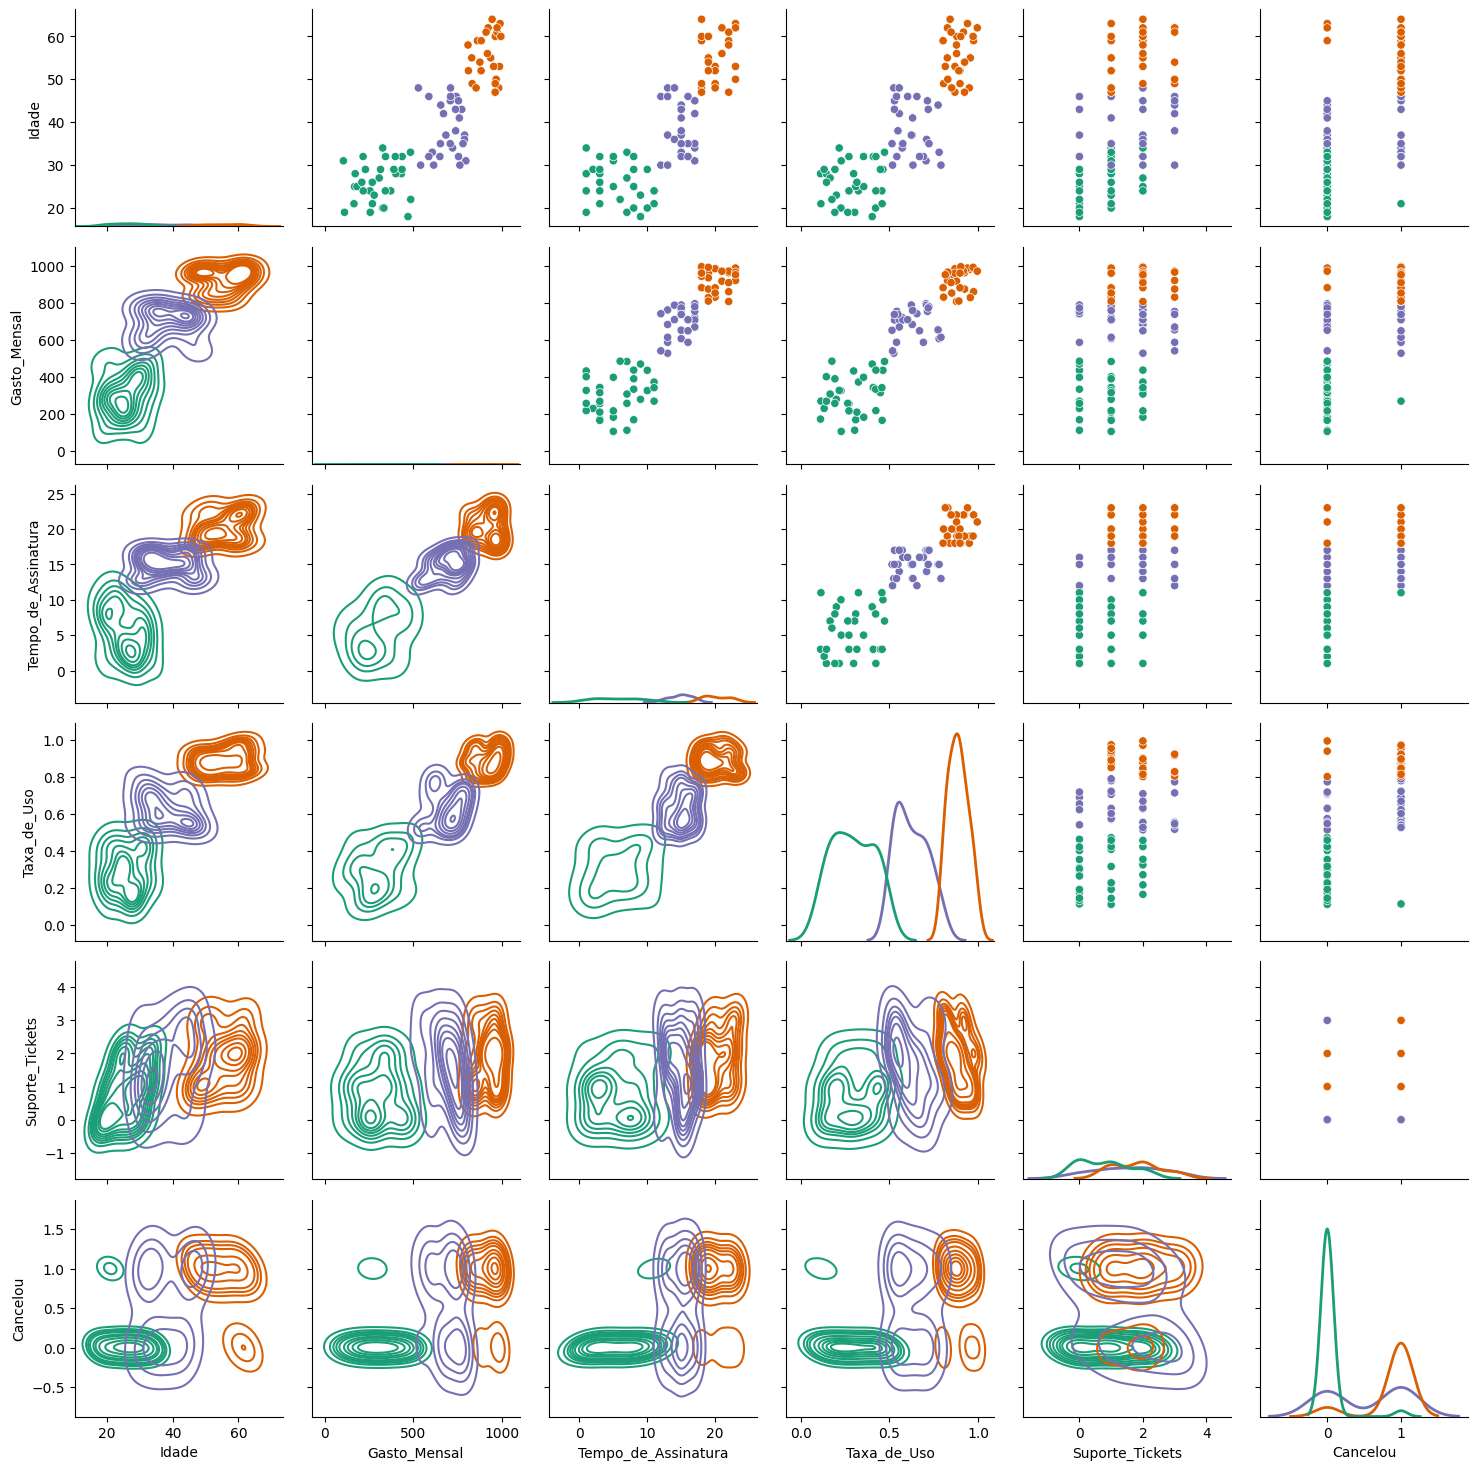

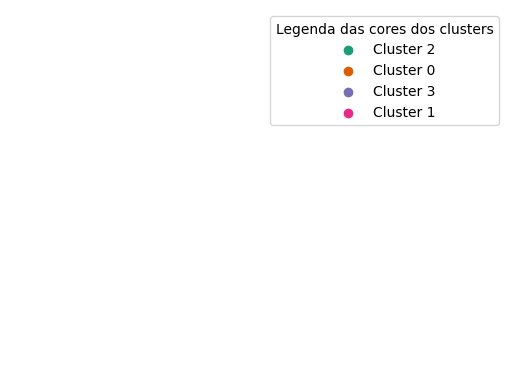

In [80]:
# Visualizar os clusters
# Pair Grid
palette = sns.color_palette('Dark2', n_colors = len(df['Cluster'].unique()))
color_map = dict(zip(df['Cluster'].unique(), palette))
# Criando o plot
g = sns.PairGrid(df_v2_limpo, hue = 'Cluster', palette = palette)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()
# Mostrando o mapa de cores
for cluster, color in color_map.items():
  plt.scatter([],[],c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda das cores dos clusters')
plt.axis('off')
plt.show()

Note que com 3 clusters não houve mais sobreposição, indicando que os dados foram bem agrupados e definidos pelo K-Means e o número 3 de clusters aparentemente é o ideal para esse conjunto de dados.

In [81]:
# Analise do cluster 1
print(df_v2_limpo[df_v2_limpo['Cluster'] == 0].mean()) 

Idade                   25.848485
Gasto_Mensal           302.863443
Tempo_de_Assinatura      5.606061
Taxa_de_Uso              0.293108
Suporte_Tickets          0.787879
Cancelou                 0.030303
Cluster                  0.000000
dtype: float64


In [82]:
# Analise do cluster 2
print(df_v2_limpo[df_v2_limpo['Cluster'] == 1].mean())

Idade                   55.444444
Gasto_Mensal           923.951700
Tempo_de_Assinatura     20.222222
Taxa_de_Uso              0.888083
Suporte_Tickets          1.814815
Cancelou                 0.888889
Cluster                  1.000000
dtype: float64


In [83]:
# Analise do cluster 3
print(df_v2_limpo[df_v2_limpo['Cluster'] == 2].mean())

Idade                   38.357143
Gasto_Mensal           697.637605
Tempo_de_Assinatura     14.928571
Taxa_de_Uso              0.626822
Suporte_Tickets          1.571429
Cancelou                 0.535714
Cluster                  2.000000
dtype: float64


**Análise do Cluster 1**

O cluster 1 é um dos clusters extremos, em que são caracterizados por um público jovem que tem um gasto mensal menor do que os demais grupos e possuem tanto tempo de assinatura quanto tempo de uso baixos. Apesar disso, esse cluster apresenta taxa de cancelamento (somente 3%), o que indica planos básicos acessíveis ou que estão conhecendo o produto. Diante disso, a empresa pode oferecer promoções, descontos e cupons de compra com o propósito de engajar esse público e incentivar a fidelização.

**Análise do Cluster 2**

O cluster 2 é o outro cluster extremo, caracterizado por clientes mais antigos, com maiores tempo de assinatura e taxa de uso, além de maior gasto a cada mês. Ou seja, são clientes fidedignos ao produto da empresa. Em geral, os clientes desse cluster possuem idade mais elevada e abrem bastante tickets de suporte, podendo indicar que tem algumas dificuldades ou dúvidas de usufruir a assinatura, o que compromete a experiência do cliente. Portanto, isso acarreta em uma elevada taxa de cancelamento por insatisfação acumulada, suporte ineficiente e preços elevados. Por isso, o ideal seria analisar o motivo do churn, como análise de NPS e feedback para retenção e melhora do atendimento e experiência do cliente.

**Análise do Cluster 3**

O cluster é caracterizado por ser mediano em praticamente todos os aspectos. Apresentam gasto e uso moderados e nem são tão novos e nem tão antigos. A taxa de cancelamento sugere ser um grupo volátil que pode cancelar a assinatura por serem sensíveis a preços ou a novas ofertas. Diante disso, compreender as percepções de valor e oferecer programas e benefícios para fidelização são estratégias que podem ser adotadas para retenção e redução de churn desse grupo. 

---

## Verificação dos Centroides

In [84]:
# Extração e visualização dos centroides
centroides = modelo_v2.cluster_centers_
print(centroides)

[[-0.9833611  -1.15445655 -1.13105336 -1.09972895 -0.59164729 -0.85201287]
 [ 1.2449823   1.11336406  1.08773561  1.16643498  0.48487723  0.87229889]
 [-0.04155735  0.28700845  0.28413927  0.17133254  0.2297384   0.16301267]]


In [ ]:
# Resetando o índice
df_sc.reset_index(drop=True, inplace=True)
df_v2.reset_index(drop=True, inplace=True)

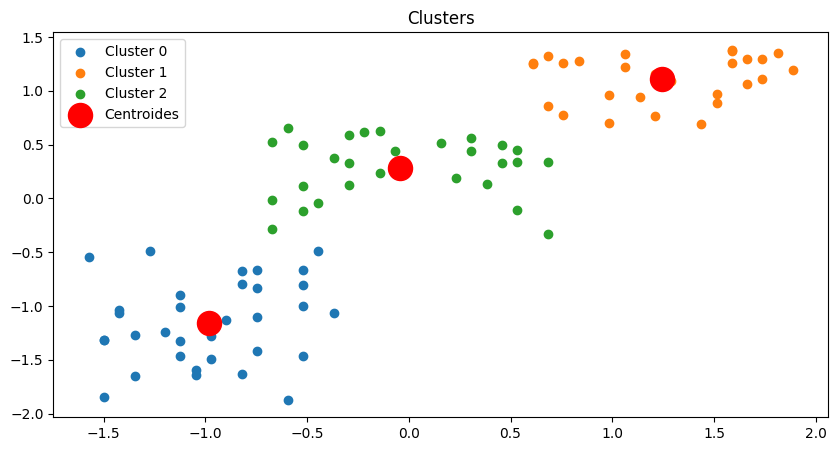

In [ ]:
# Verificação dos clusters graficamente com seus respectivos centróides
plt.figure(figsize = (10,5))
for i in range(3):
  mask = df_v2['Cluster'] == i
  plt.scatter(df_sc[mask].iloc[:,0], df_sc[mask].iloc[:,1], label = f'Cluster {i}')
# Marcação dos centróides
plt.scatter(modelo_v2.cluster_centers_[:,0], modelo_v2.cluster_centers_[:,1], s = 300, c = 'red', label = 'Centroides')
plt.legend()
plt.title('Clusters')
plt.show()

In [120]:
# Observações atribuidas a cada cluster
print('Distribuição por Cluster',df_v2['Cluster'].value_counts())
print('\nDistribuição Percentual por Cluster',df_v2['Cluster'].value_counts(normalize=True).round(2))

Distribuição por Cluster Cluster
0    33
2    28
1    27
Name: count, dtype: int64

Distribuição Percentual por Cluster Cluster
0    0.38
2    0.32
1    0.31
Name: proportion, dtype: float64


Observe que a distribuição está proporcional para cada cluster.

---

## Score da Silhueta

In [91]:
# Score
score = silhouette_score(df_sc, df_v2['Cluster'])
print(score)

0.40340661595781013


In [92]:
# Importação do pacote silhouette_samples
from sklearn.metrics import silhouette_samples

In [93]:
# Valores
vals = silhouette_samples(df_sc, df_v2['Cluster'])

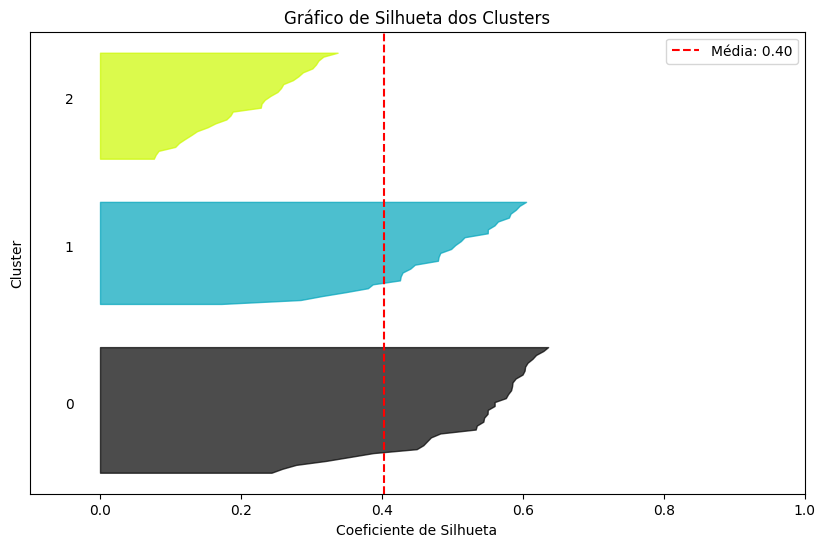

In [ ]:
import matplotlib.cm as cm

# Labels (rótulos de cluster) atribuídos pelo modelo
labels = modelo_v2.labels_
n_clusters = len(np.unique(labels))

# Score médio da silhueta (quanto mais próximo de 1, melhor)
silhouette_avg = silhouette_score(df_sc, labels)

# Valores individuais de silhueta para cada ponto
sample_silhouette_values = silhouette_samples(df_sc, labels)

# --- Criação do gráfico ---
fig, ax1 = plt.subplots(figsize=(10, 6))
y_lower = 10  # posição inicial no eixo y

for i in range(n_clusters):
    # Coleta os valores da silhueta para o cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Rótulo do cluster no meio do grupo
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # espaçamento entre os clusters

# --- Ajustes visuais ---
ax1.set_title("Gráfico de Silhueta dos Clusters")
ax1.set_xlabel("Coeficiente de Silhueta")
ax1.set_ylabel("Cluster")

# Linha vertical indicando o valor médio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Média: {silhouette_avg:.2f}")

ax1.set_yticks([])  # remove marcações do eixo y
ax1.set_xlim([-0.1, 1])
ax1.legend()
plt.show()

A análise de silhueta mensura o nível de ajuste de cada ponto de dado em seu cluster. A média varia de 0 até 1, onde 0 indica clusters sobrepostos e/ou mal definidos, enquanto que a pontuação 1 indica que os clusters estão bem agrupados. Para nosso caso, uma pontuação de 0.40 indica que os cluster não estão sobrepostos, possuem relativamente uma boa distinção.